    LSTM MODEL:

Univariate model using sequences of Closing price to predict future prices.

In [1]:
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

os.chdir('/Users/tomkuhle/OneDrive/Documents/Programming/facebook_LSTM/')

In [2]:
def import_data():
    """
    import facebook data and filter for the price at the end of the trading day
    """
    data = pd.read_csv("facebook_day.csv", index_col = 'Local Time')
    data = data[['Close']]
    
    return data

input_data = import_data()

<Figure size 2400x1200 with 0 Axes>

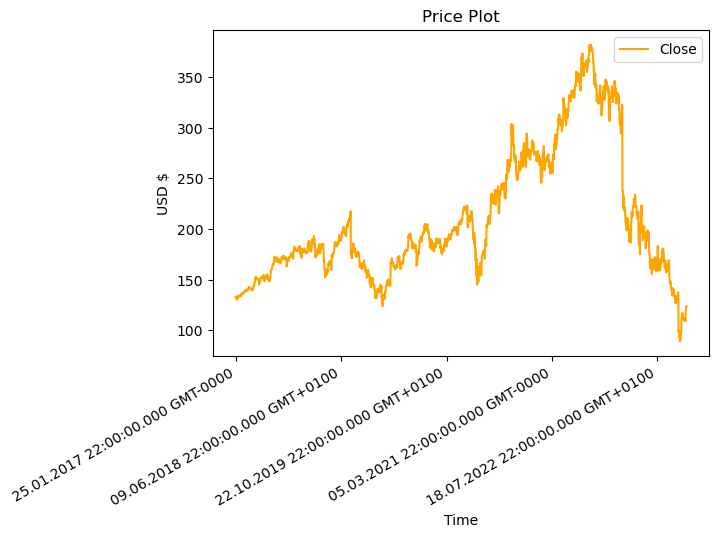

In [4]:
def plot_data(data):
    """
    line plot of the close price
    """
    plt.style.use('default')
    %matplotlib inline

    plt.figure(figsize=(16, 8), dpi=150)
    data.plot(label='Price', color='orange')
    plt.title('Price Plot')
    plt.xlabel('Time')
    plt.ylabel('USD $')
    plt.gcf().autofmt_xdate()
    plt.legend()
    
    pass

plot_data(input_data)

In [101]:
def preprocessing(data):
    """
    scale the price between 0 and 1
    """
    data_matrix = np.array(data)
#         np.seterr(divide = 'ignore')
#         log_values = np.where(data_matrix != 0, np.log(data_matrix), 0)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data_matrix)
    
    return scaled_data, scaler

preprocessed_data, scaler_min_max = preprocessing(input_data)

print(preprocessed_data[:5])

[[0.14961677]
 [0.14746784]
 [0.14746784]
 [0.14746784]
 [0.14340875]]


In [116]:
class TrainValidTestSplit:
    """
    a class to split the training, validation and testing data
    """
    
    def __init__(self, preprocessed_data, training_proportion, validation_proportion, sequence_length):
        
        self.preprocessed_data = preprocessed_data
        self.training_proportion = training_proportion
        self.validation_proportion = validation_proportion
        self.sequence_length = sequence_length
        self.training_data_len = int(
            np.ceil( 
            len(preprocessed_data) * training_proportion 
            )
        )
        self.validation_data_len = int(
            np.ceil( 
                len(preprocessed_data) * validation_proportion 
            )
        )

    
    def training_split(self):

        train_data = self.preprocessed_data[
            0:self.training_data_len, :
        ]
        x_train = []
        y_train = []

        for i in range(self.sequence_length, len(self.preprocessed_data)):
            x_train.append(
                self.preprocessed_data[i-self.sequence_length:i, 0]
            )
            y_train.append(
                self.preprocessed_data[i, 0]
            )

        x_train, y_train = np.array(x_train), np.array(y_train)

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        return x_train, y_train

    
    def validation_split(self):
        
        validation_data = self.preprocessed_data[
            self.training_data_len : self.training_data_len + self.validation_data_len,
            :
        ]
        x_validation = []
        y_validation = []

        for i in range(self.sequence_length, len(validation_data)):
            x_validation.append(validation_data[i-self.sequence_length:i, 0])
            y_validation.append(validation_data[i, 0])

        x_validation, y_validation = np.array(x_validation), np.array(y_validation)

        x_validation = np.reshape(x_validation, (x_validation.shape[0], x_validation.shape[1], 1))
        
        return x_validation, y_validation

    
    def testing_split(self):
        
        test_data = self.preprocessed_data[
            self.training_data_len + self.validation_data_len - self.sequence_length :, 
            :
        ]
        x_test = []
        y_test = self.preprocessed_data[
            self.training_data_len + self.validation_data_len :,
            :
        ]

        for i in range(self.sequence_length, len(test_data)):
            x_test.append(test_data[i-self.sequence_length:i, 0])

        x_test = np.array(x_test)

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        return x_test, y_test

# Define the class
train_valid_test_split = TrainValidTestSplit(
    preprocessed_data,
    training_proportion=0.8, 
    validation_proportion=0.1, 
    sequence_length = 14
)

x_train, y_train = train_valid_test_split.training_split()
x_validation, y_validation = train_valid_test_split.validation_split()
x_test, y_test = train_valid_test_split.testing_split()

In [128]:
print(train_valid_test_split.training_data_len)

1712


    LSTM MODEL

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 14, 32)            4352      
                                                                 
 lstm_19 (LSTM)              (None, 16)                3136      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 3s 35ms/step - loss: 0.1004 - val_loss: 0.0506
Epoch 2/10
22/22 [==============================] - 0s 19ms/step - loss: 0.0516 - val_loss: 0.1041
Epoch 3/10
22/22 [==============================] - 0s 18ms/step - loss: 0.0475 - val_loss: 0.0819
Epoch 4/10
22/22 [=

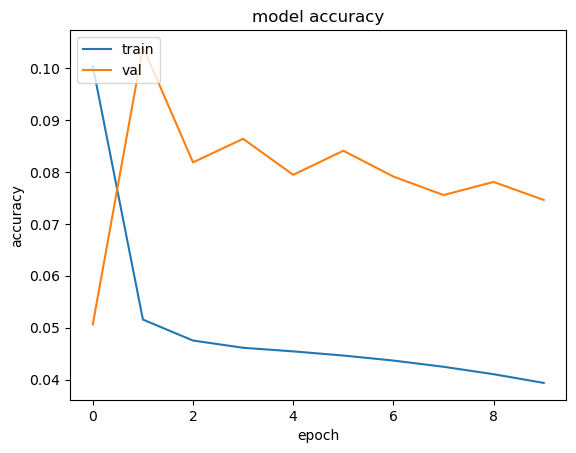

In [117]:
# define model
class LstmModel:
    
    def __init__(self, 
                 x_train, 
                 y_train, 
                 x_validation, 
                 y_validation, 
                 first_layer_nodes,
                 second_layer_nodes, 
                 batch_size, 
                 epochs):
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_validation = x_validation
        self.y_validation = y_validation
        self.first_layer_nodes = first_layer_nodes
        self.second_layer_nodes = second_layer_nodes
        self.batch_size = batch_size
        self.epochs = epochs
        
    def model(self):
    
        model = Sequential()
        model.add(LSTM(
            self.first_layer_nodes, 
            activation='sigmoid', 
            return_sequences=True, 
            input_shape=(self.x_train.shape[1], 1)))
        model.add(LSTM(
            self.second_layer_nodes, 
            activation='sigmoid'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.summary()

        history = model.fit(x=self.x_train,
                            y=self.y_train, 
                            batch_size=self.batch_size,
                            epochs=self.epochs, 
                            verbose=1,
                            validation_data=(
                                self.x_validation, 
                                self.y_validation)
                           )

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
        return model


lstm_model = LstmModel(
    x_train,
    y_train,
    x_validation, 
    y_validation, 
    first_layer_nodes=32, 
    second_layer_nodes=16,
    batch_size=100,
    epochs=10
)

model = lstm_model.model()

In [127]:
# Get the models predicted price values
def predict_test_data(model, x_test, scaler):

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions


# Get the root mean squared error (RMSE)
def calc_error(predictions, y_test):
    
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))


predictions = predict_test_data(model, x_test, scaler_min_max)
print(f"\ntop 5 predictions: {predictions[:5]}")

rmse = calc_error(predictions, y_test)
print(f"\nroot mean squared error: {rmse}")

7/7 [==============================] - 0s 7ms/step

top 5 predictions: [[206.69148]
 [206.4443 ]
 [206.41943]
 [206.40804]
 [205.96783]]

root mean squared error: 200.35336497294222


/var/folders/qv/10v_7b5s00z1kw33s7_264180000gn/T/ipykernel_33701/723080381.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


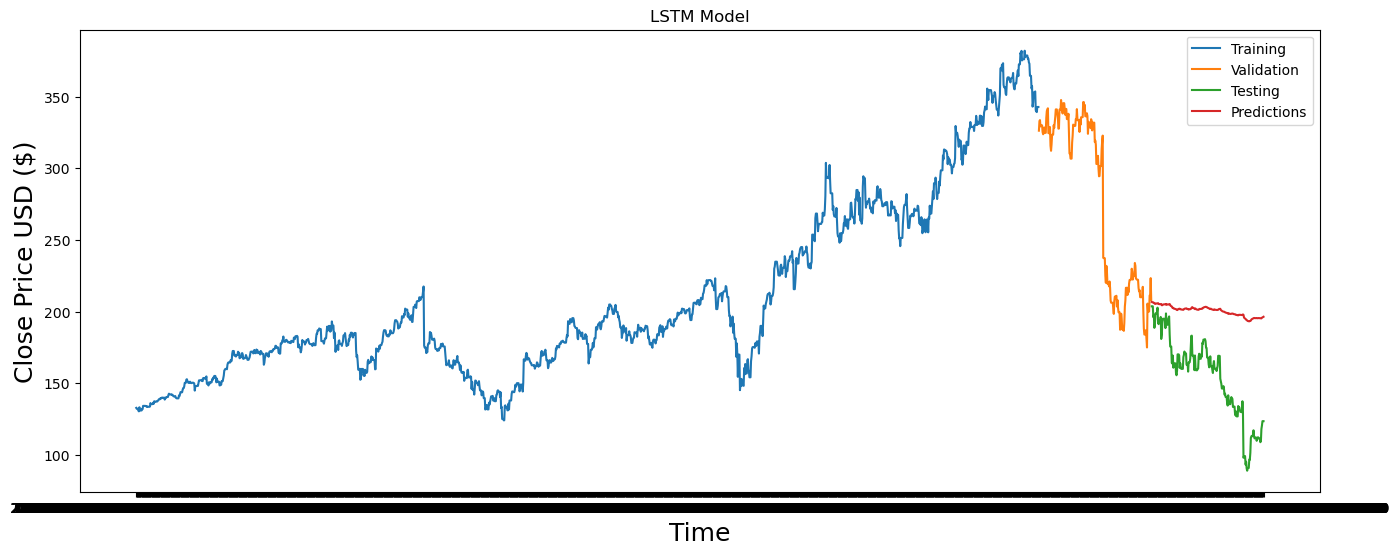

In [138]:
# Plot the data
train = input_data[:train_valid_test_split.training_data_len]
valid = input_data[
    train_valid_test_split.training_data_len 
    : train_valid_test_split.training_data_len 
    + train_valid_test_split.validation_data_len
]
test = input_data[
    train_valid_test_split.training_data_len
    + train_valid_test_split.validation_data_len:
]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Testing', 'Predictions'], loc='upper right')
plt.show()

In [63]:
# import sys
# print(sys.path)
# sys.path.remove('{cwd}')
# print(sys.path)